In [ ]:
D = librosa.stft(feature)

In [1]:
import os
import sys
import glob
import tqdm
import sklearn
import random
import librosa
import numpy as np
import pandas as pd
import librosa.display
#import tensorflow as tf
from matplotlib import patches
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras
import Metrics
from keras.utils import plot_model
#import numpy as np
import numpy.random as r
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
dataset_dir = "/vita/Jtrainpython/zwuk/training_data/"
train_dataset_dir = os.path.join(dataset_dir, "Training_Data/")

!tree {train_dataset_dir} -L 1

‘«ЁиЄ®¬ ¬­®Ј® Ї а ¬Ґва®ў: 1


In [3]:
print(train_dataset_dir)


/vita/Jtrainpython/zwuk/training_data/Training_Data/


In [4]:
wav_paths = sorted(glob.glob(os.path.join(train_dataset_dir, '**/*.wav'), recursive=True))
random.shuffle(wav_paths)

train_paths = wav_paths[:40000]
dev_paths = wav_paths[40000:]

train_human  = sorted(filter(lambda path: "human" in path, train_paths))
train_spoof = sorted(filter(lambda path: "spoof" in path, train_paths))
dev_human  = sorted(filter(lambda path: "human" in path, dev_paths))
dev_spoof = sorted(filter(lambda path: "spoof" in path, dev_paths))

print("Train Human: %d" % len(train_human))
print("Train Spoof: %d" % len(train_spoof))
print("Dev   Human: %d" % len(dev_human))
print("Dev   Spoof: %d" % len(dev_spoof))

Train Human: 8268
Train Spoof: 31732
Dev   Human: 2054
Dev   Spoof: 7946


In [5]:
a=[1,2,3,4,5]
print(a[:2])
print(a[2:])
a=a[2:]
a=a[:5]
print(a)

[1, 2]
[3, 4, 5]
[3, 4, 5]


(66000,)


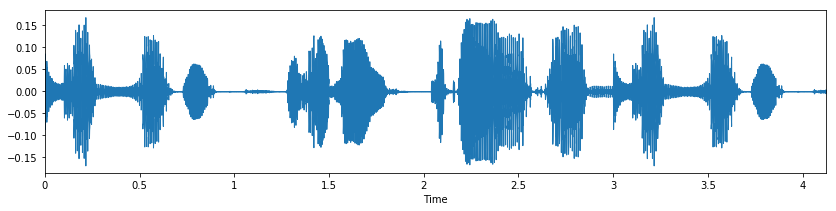

In [6]:
def get_myfeature(wav_path, length=66000, random_start=False):
    try:
        #print(random_start)
        x, sr = librosa.load(wav_path, sr=None)
        assert sr == 16000
        if length > len(x):
            x = np.concatenate([x] * int(np.ceil(length/len(x))))
        #if random_start:
            #x = x[random.randint(0, len(x) - length):]
            #print('----',random.randint(0, len(x) - length))
        feature = x[:length]
        return feature ################/ np.max(np.abs(feature))
    except Exception as e:
        print("Error with getting feature from %s: %s" % (wav_path, str(e)))
        return None



def get_feature(wav_path, length=66000, random_start=False):
    try:
        #print(random_start)
        x, sr = librosa.load(wav_path, sr=None)
        assert sr == 16000
        if length > len(x):
            x = np.concatenate([x] * int(np.ceil(length/len(x))))
        if random_start:
            x = x[random.randint(0, len(x) - length):]
            #print('----',random.randint(0, len(x) - length))
        feature = x[:length]
        return feature / np.max(np.abs(feature))
    except Exception as e:
        print("Error with getting feature from %s: %s" % (wav_path, str(e)))
        return None

feature = get_myfeature(random.choice(train_human), length=66000, random_start=False)
plt.figure(figsize=(14, 3))
librosa.display.waveplot(feature, sr=16000)
print(feature.shape)

(66000,)


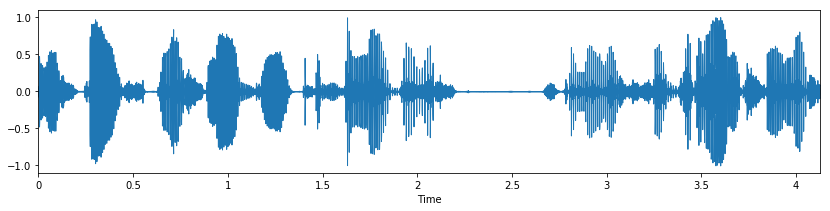

In [7]:
feature = get_feature(train_human[274], length=66000, random_start=True)
plt.figure(figsize=(14, 3))
librosa.display.waveplot(feature, sr=16000)
print(feature.shape)

32


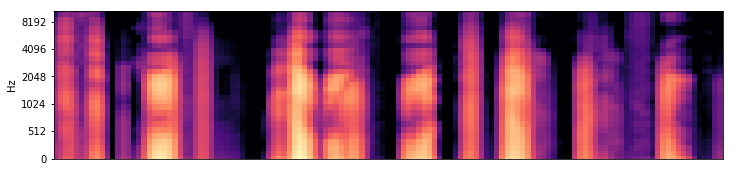

In [8]:
y_harmonic, y_percussive = librosa.effects.hpss(feature)
sr=16000
# What do the spectrograms look like?
# Let's make and display a mel-scaled power (energy-squared) spectrogram
S_harmonic   = librosa.feature.melspectrogram(y_harmonic**2-y_percussive**2, sr=sr, n_mels=32)
S_percussive = librosa.feature.melspectrogram(y_percussive, sr=sr, n_mels=16)
#print((log_Sh))
#print((log_Sh.shape[1]))
# Convert to log scale (dB). We'll use the peak power as reference.
log_Sh = librosa.power_to_db(S_harmonic, ref=np.max)
log_Sp = librosa.power_to_db(S_percussive, ref=np.max)
print((log_Sh.shape[0]))
# Make a new figure
plt.figure(figsize=(12,6))

plt.subplot(2,1,1)
# Display the spectrogram on a mel scale
#librosa.display.specshow(sklearn.preprocessing.scale(((S_harmonic))**2+((S_percussive))**2, axis=1), sr=sr, y_axis='mel')
librosa.display.specshow(log_Sh, sr=sr, y_axis='mel')

#librosa.display.specshow(sklearn.preprocessing.scale(log_Sh, axis=1), sr=sr, y_axis='mel')

10000
(1, 66000, 1)
(1, 2)


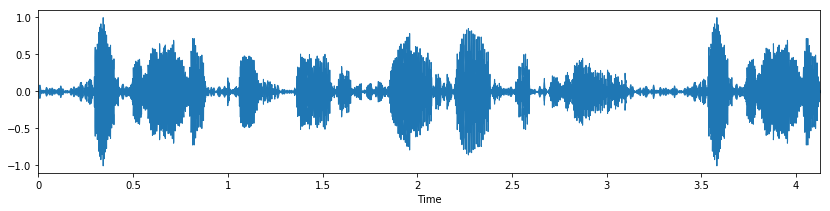

In [8]:
class DevDataGenerator(keras.utils.Sequence):
    def __init__(self, human_paths, spoof_paths, feature_extractor):
        self.human_paths = human_paths
        self.spoof_paths = spoof_paths
        self.paths = human_paths + spoof_paths
        self.labels = [0] * len(human_paths) + [1] * len(spoof_paths)
        self.feature_extractor = feature_extractor
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        feature = self.feature_extractor(self.paths[index])[np.newaxis, ..., np.newaxis]
        return feature, keras.utils.to_categorical([self.labels[index]], num_classes=2)
        
dev_get_feature = lambda path: get_feature(path, length=66000, random_start=False)
dev_data_generator = DevDataGenerator(dev_human, dev_spoof, dev_get_feature)
features, labels = dev_data_generator[0]
plt.figure(figsize=(14, 3))
librosa.display.waveplot(features[0, ..., 0], sr=16000)
print(len(dev_data_generator))
print(features.shape)
print(labels.shape)

129
512


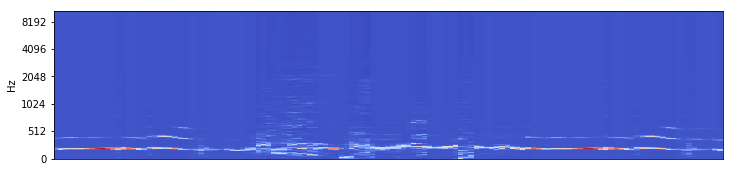

In [10]:
feature = get_feature(train_human[87], length=66000, random_start=True)

y_harmonic, y_percussive = librosa.effects.hpss(feature)
sr=16000

S_harmonic   = librosa.feature.melspectrogram(y_harmonic, sr=sr, n_mels=512)
S_percussive = librosa.feature.melspectrogram(y_percussive, sr=sr, n_mels=16)
#print((log_Sh))
print((log_Sh.shape[1]))
# Convert to log scale (dB). We'll use the peak power as reference.
log_Sh = librosa.power_to_db(S_harmonic, ref=np.max)
log_Sp = librosa.power_to_db(S_percussive, ref=np.max)
print((log_Sh.shape[0]))
# Make a new figure
plt.figure(figsize=(12,6))

plt.subplot(2,1,1)

librosa.display.specshow(sklearn.preprocessing.scale(S_harmonic, axis=0), sr=sr, y_axis='mel')

#librosa.display.specshow(sklearn.preprocessing.scale(log_Sh, axis=1), sr=sr, y_axis='mel')

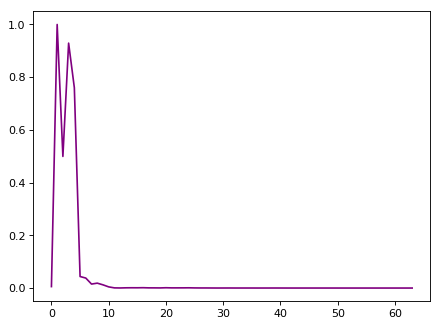

In [11]:
feature = get_feature(train_spoof[1618], length=66000, random_start=True)

y_harmonic, y_percussive = librosa.effects.hpss(feature)
sr=16000

S_harmonic   = librosa.feature.melspectrogram(y_harmonic, sr=sr, n_mels=64)
#sklearn.preprocessing.scale(S_harmonic, axis=0)
sumc=0
spec=[]
m1=64
mn=129
for ii in range(m1):
    sumc=0
    count=0
    for jj in range(mn):
        sumc=S_harmonic[ii,jj]+sumc
        count=count+1
    if  count>0 :
        spec.append(sumc/count)
    else:
        spec.append(0)
maxsp=np.max(np.abs(spec))
if  maxsp>0 :
    spec=spec/ maxsp
            
dpi = 80
fig = plt.figure(dpi = dpi, figsize = (512 / dpi, 384 / dpi) )


x = np.arange(0.0,len(spec) , 1)
y = np.array(spec,dtype=np.float)
plt.plot(x, y,color = 'purple')


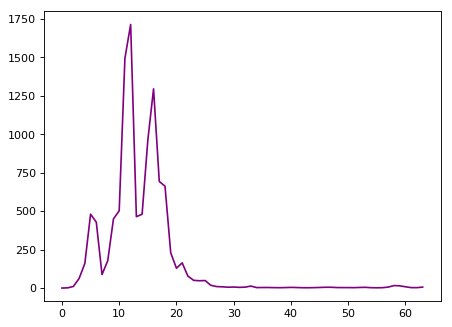

In [13]:
#feature = get_feature(train_human[10], length=66000, random_start=True)
spec1=spec
y_harmonic, y_percussive = librosa.effects.hpss(feature)
sr=16000

S_harmonic   = librosa.feature.melspectrogram(y_percussive, sr=sr, n_mels=64)
#sklearn.preprocessing.scale(S_harmonic, axis=0)
sumc=0
spec=[]
m1=64
mn=129
for ii in range(m1):
    sumc=0
    count=0
    for jj in range(mn):
        sumc=S_harmonic[ii,jj]+sumc
        count=count+1
    if  count>0 :
        spec.append(sumc/count)
    else:
        spec.append(0)
maxsp=np.max(np.abs(spec))
if  maxsp>0 :
    spec=spec/ maxsp
    


spec=[]    
for row in S_harmonic:
    spec.append(sum(row)) 
    
dpi = 80
fig = plt.figure(dpi = dpi, figsize = (512 / dpi, 384 / dpi) )


x = np.arange(0.0,len(spec) , 1)
y = np.array(spec,dtype=np.float)
plt.plot(x, y,color = 'purple')


(1025, 129)
513


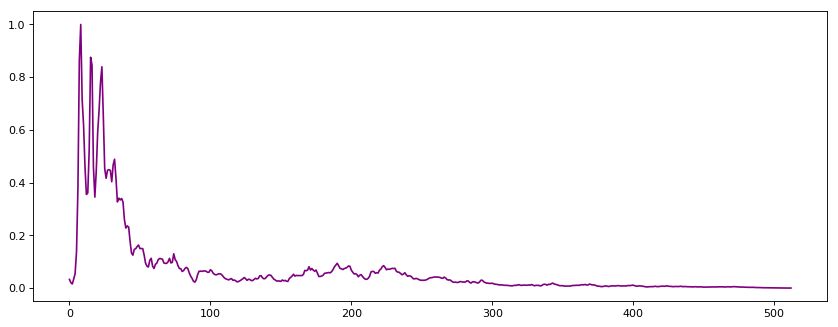

In [19]:

feat = get_feature(train_human[19], length=66000, random_start=True)
D = librosa.stft(feat,n_fft=2048)
#S_harmonic=librosa.amplitude_to_db(np.abs(D), ref=1)
print(S_harmonic.shape)
S_harmonic=np.abs(D)
#plt.figure(figsize=(12,6))

#plt.subplot(2,1,1)
# Display the spectrogram on a mel scale
#librosa.display.specshow(sklearn.preprocessing.scale(((S_harmonic))**2+((S_percussive))**2, axis=1), sr=sr, y_axis='mel')
########3librosa.display.specshow(S_harmonic, sr=sr, y_axis='mel')
#y_percussive = librosa.effects.percussive (feat)   
#S_harmonic   = librosa.feature.melspectrogram(y_percussive, sr=sr, n_mels=koef)
#spec=[]    
#for row in S_harmonic:
#    spec.append(sum(row)) 
y_harmonic, y_percussive = librosa.effects.hpss(feat)
   
    #y_percussive = librosa.effects.percussive (feat)  
    
    
S_harmonic   = librosa.feature.melspectrogram(y_percussive, sr=sr, n_mels=128)
spec=[]    
spec1=[]
spec2=[]

for row in S_harmonic:
    ab=sum(row)
    spec1.append(ab)
    spec.append(ab*ab)
        
    #y_harmonic= librosa.effects.harmonic(feat)
S_harmonic  = librosa.feature.melspectrogram(y_harmonic, sr=sr, n_mels=128)
for row in S_harmonic:
    ab=sum(row)
    spec2.append(ab)
    spec.append(ab*ab)
for x, y in zip(spec1, spec2):
    b=x + y
    spec.append(b*b)
for x, y in zip(spec1, spec2):
    b=x + y
    d=y - x
    spec.append(b*d)
    
#k.append(map(lambda x, y: x * y, spec1, spec2))#[a*b for a,b in zip(spec1, spec2)]
#spec.append(k )

#[a*b for a,b in zip(lista,listb)]    
#cc=list(x * y  )
#cc=(np.array(spec1)*np.array(spec2))
#print(cc)
#map(lambda x, y: x * y, spec1, spec2)
#spec.append(cc)
            
            
#feat = get_feature(dev_human[ij], length=66000, random_start=False)
    #полный спектр
D = librosa.stft(feat,n_fft=1024)
S_harmonic=librosa.amplitude_to_db(np.abs(D), ref=np.max)

S_harmonic=np.abs(D)
spec=[]    
    
for row in S_harmonic:
    spec.append(sum(row))

maxsp=np.max(np.abs(spec))
if  maxsp>0 :
    spec=spec/ maxsp  
print(len(spec))    
dpi = 80
fig = plt.figure(dpi = dpi, figsize = (1024 / dpi, 384 / dpi) )


x = np.arange(0.0,len(spec) , 1)
y = np.array(spec,dtype=np.float)
plt.plot(x, y,color = 'purple')


In [21]:
%%time
fs=16000
koef=1025
sr=16000
lensign=koef#129*koef#2580
nmall=66000
fs=16000
tr_human =[]
y_human = []
y_spoof = []
tr_spoof = []
#lst=[]    
mm=len(train_human)
#spec=[1.0]*koef
for ij in range(mm):
    feat = get_feature(train_human[ij], length=66000, random_start=False)
    #полный спектр
    D = librosa.stft(feat,n_fft=2048)
    #S_harmonic=librosa.amplitude_to_db(np.abs(D), ref=np.max)
    S_harmonic=np.abs(D)
    
    spec=[]    
    
    for row in S_harmonic:
        spec.append(sum(row))
        
          
    maxsp=np.max(np.abs(spec))
    if  maxsp>0 :
        spec=spec/maxsp
  
    tr_human.append(spec)
    
    #y_human.append(1)
    y_human.append(0)
    if ij%100 == 0:
        print(ij)

#========================дополнительные для человеков        
mm=len(train_human)
for ij in range(1,mm,3):
    
 
    feat = get_feature(train_human[ij], length=66000, random_start=True)
    #полный спектр
    D = librosa.stft(feat,n_fft=2048)
    #S_harmonic=librosa.amplitude_to_db(np.abs(D), ref=np.max)
    S_harmonic=np.abs(D)
    spec=[]    
    
    for row in S_harmonic:
        spec.append(sum(row))
        
    maxsp=np.max(np.abs(spec))
    if  maxsp>0 :
        spec=spec/maxsp
    #print(max(spec))
    
    tr_human.append(spec)
    
    #y_human.append(1)
    y_human.append(0)
    if ij%100 == 0:
        print(ij)
        
        
        
        
#=========================        
        
mm=len(train_spoof) 
#spec=[1.0]*koef
for ij in range(mm):
    #lst=[]
    feat = get_feature(train_spoof[ij], length=66000, random_start=False)
    #полный спектр
    D = librosa.stft(feat,n_fft=2048)
    #S_harmonic=librosa.amplitude_to_db(np.abs(D), ref=np.max)
    S_harmonic=np.abs(D)
    spec=[]    
    
    for row in S_harmonic:
        spec.append(sum(row))
        
    #print(len(spec))
    maxsp=np.max(np.abs(spec))
    if  maxsp>0 :
        spec=spec/ maxsp
  
    tr_spoof.append(spec)
    
    y_spoof.append(1)
    if ij%100 == 0:
        print(ij)
#=========================  дополнительные для роботов      
        
mm=len(train_spoof) 
#spec=[1.0]*koef
for ij in range(1,mm,20):
    #lst=[]
    feat = get_feature(train_spoof[ij], length=66000, random_start=True)
    #полный спектр
    D = librosa.stft(feat,n_fft=2048)
    #S_harmonic=librosa.amplitude_to_db(np.abs(D), ref=np.max)
    S_harmonic=np.abs(D)
    spec=[]    
    
    for row in S_harmonic:
        spec.append(sum(row))
        
    #print(len(spec))
    maxsp=np.max(np.abs(spec))
    if  maxsp>0 :
        spec=spec/ maxsp
  
    tr_spoof.append(spec)
    
    y_spoof.append(1)
    if ij%100 == 0:
        print(ij)
        
Xtrn = tr_human+tr_spoof
Ytrn =y_human+y_spoof

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
100
400
700
1000
1300
1600
1900
2200
2500
2800
3100
3400
3700
4000
4300
4600
4900
5200
5500
5800
6100
6400
6700
7000
7300
7600
7900
8200
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
94

In [20]:
%%time
#fs=16000
#koef=512
#sr=16000
tr_human =[]
y_human = []
y_spoof = []
tr_spoof = []
#spec=[1.0]*koef    
mm=len(dev_human)
for ij in range(mm):
    
    feat = get_feature(dev_human[ij], length=66000, random_start=False)
    #полный спектр
    D = librosa.stft(feat,n_fft=2048)
    #S_harmonic=librosa.amplitude_to_db(np.abs(D), ref=np.max)
    S_harmonic=np.abs(D)
    spec=[]    
    
    for row in S_harmonic:
        spec.append(sum(row))
        
    #print(len(spec),ij )  
    maxsp=np.max(np.abs(spec))
    if  maxsp>0 :
        spec=spec/maxsp
  
    tr_human.append(spec)
   
    y_human.append(0)
    if ij%50 == 0:
        print(ij)
        
mm=len(dev_spoof)  
#spec=[1.0]*koef
for ij in range(mm):
   
    
    feat = get_feature(dev_spoof[ij], length=66000, random_start=False)
    #полный спектр
    D = librosa.stft(feat,n_fft=2048)
    #S_harmonic=librosa.amplitude_to_db(np.abs(D), ref=np.max)
    S_harmonic=np.abs(D)
    spec=[]    
    
    for row in S_harmonic:
        spec.append(sum(row))
        
    maxsp=np.max(np.abs(spec))
    if  maxsp>0 :
        spec=spec/ maxsp
  
    tr_spoof.append(spec)
    y_spoof.append(1)
    if ij%50 == 0:
        print(ij)

Xtest = tr_human+tr_spoof
Ytest =y_human+y_spoof



0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
5000
5050
5100
5150
5200
5250
5300
5350
5400
5450
5500
5550
5600
5650
5700
5750
5800
5850
5900
5950
6000
6050
6100
6150
6200
6250
6300
6350
6400
6450
6500
6550
6600
6650
6700
6750
6800
6850
6900
6950
7000
7050
7100
7150
7200
7250
7300
7350
7400
7450
7500
7550
7600
7650
7700
7750
7800
7850
7900
Wall time: 27min 50s


In [27]:
#Ytest= np.array(Ytest)
#Xtest = np.array(Xtest)
#Xtest = Xtest.reshape(-1,lensign)
#print(lensign)
#print(Xtest.shape)
#Xtrn.shape

In [22]:
tr_human =[]
y_human = []
y_spoof = []
tr_spoof =[]

#print(Xtest[120])
Ytrn= np.array(Ytrn)
Ytest= np.array(Ytest)


Xtest = np.array(Xtest)
#Xtest = Xtest.reshape(-1,lensign)
Xtest = Xtest.reshape(-1,koef)
Xtest.shape

Xtrn = np.array(Xtrn)
#Xtrn = Xtrn.reshape(-1,lensign)
Xtrn = Xtrn.reshape(-1,koef)

Xtrn.shape





(44343, 1025)

In [ ]:
===========================

for ij in range(len(Xtrn)):
    for ii in range(lensign):
        if np.isnan(Xtrn[ij,ii]):
            Xtrn[ij,ii]=0
            print(ij)

for ij in range(len(Xtest)):
    for ii in range(lensign):
        if np.isnan(Xtest[ij,ii]):
            Xtest[ij,ii]=0
            print(ij)


#на этом данные готовы = > дальше нейросеть

In [23]:

from scipy.optimize import brentq
from scipy.interpolate import interp1d
from sklearn.metrics import roc_curve


In [21]:
#print(Xtest[10])

In [143]:
# Возвращает модель                           activation='tanh'softplus
def create_model():
    #model = tf.keras.models.Sequential([
    model = keras.models.Sequential([
       
    #keras.layers.Dense(50, activation=tf.nn.relu, input_shape=(70,)),
    #keras.layers.Flatten( ),    
    #keras.layers.Dropout(0.25),
    #keras.layers.Conv2D(8, activation='tanh',kernel_size=(1,1)),
        
    #keras.layers.Flatten(data_format=None),
    keras.layers.Dense(128, activation='tanh',input_shape=(koef,)),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.15),   
    #keras.layers.Dense(16, activation='tanh'),
    #keras.layers.Dropout(0.15),    
    keras.layers.Dense(2, activation=tf.nn.softmax)
    #keras.layers.Dense(2, activation='sigmoid')    
    ])
  
    model.compile(optimizer=tf.train.AdamOptimizer(learning_rate=0.001), 
                 loss=tf.keras.losses.sparse_categorical_crossentropy,
                 #loss='binary_crossentropy',
                 metrics=['accuracy'])
    
    
    #model.compile(optimizer=tf.train.AdagradOptimizer(learning_rate=0.01), #momentum=.9
    #            loss=tf.keras.losses.sparse_categorical_crossentropy,
    #            metrics=['accuracy'])
    
  
    #model.compile(optimizer=tf.train.AdadeltaOptimizer(learning_rate=0.001), #momentum=.9
    #            loss=tf.keras.losses.sparse_categorical_crossentropy,
     #           metrics=['accuracy'])




    return model

In [144]:
keras.backend.clear_session()
# Создадим модель
model = create_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
Total params: 135,522
Trainable params: 135,522
Non-trainable params: 0
_________________________________________________________________


In [145]:
#checkpoint_path = "training_zwuk/cp.ckpt"
#checkpoint_dir = os.path.dirname(checkpoint_path)
# Укажем эпоху в имени файла (переведем ее в строки при помощи `str.format`)
checkpoint_path = "training_zwuk/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)



# Создадим контрольную точку при помощи callback функции
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                 save_weights_only=True,
                                                 verbose=1,
                                                # Сохраняем веса через каждые 5 эпох
                                                  period=50)

#model = create_model()

#Use tf.train.CheckpointManager to manage checkpoints rather than manually editing the Checkpoint proto.

In [146]:
%%time
#from scipy.optimize import brentq
#from scipy.interpolate import interp1d
#from sklearn.metrics import roc_curve
from sklearn import metrics

eer=0.16
dt=0
while eer > 0.026:
    
    epoch_step=20
    if eer<0.035:
        epoch_step=1
        
    history =model.fit(Xtrn, Ytrn, epochs =epoch_step, 
          validation_data = (Xtest,Ytest),
          batch_size=20,
          verbose=2,
          shuffle=True,
          callbacks = [cp_callback])  # передаем callback обучению



    y0_score=[]
    y1_score=[]
    #score = model.evaluate(Xtest, Ytest, verbose=0)
    #print(len(Ytest))
    score = model.predict(Xtest, batch_size=1)
    for ii in range(len(Ytest)):
        #y0_score.append(score[ii][0])
        y1_score.append(score[ii][1])
        #print(Ytest[ii],'   ',score[ii][0])
        #if ii%100 == 0:
        #    print('I=',ii)
    #y0_score=np.array(y0_score)
    y1_score=np.array(y1_score)
    #fpr, tpr, thresholds = roc_curve(y, y_score, pos_label=1)
    fpr, tpr, thresholds = metrics.roc_curve(Ytest, y1_score, pos_label=None)
    eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
    #thresh = interp1d(fpr, thresholds)(eer)
    
    print('   Метрика EER  ',eer * 100, '%')
    dt=dt#+10

Train on 44343 samples, validate on 10000 samples
Epoch 1/20
 - 29s - loss: 0.3921 - acc: 0.8347 - val_loss: 0.2739 - val_acc: 0.8960
Epoch 2/20
 - 15s - loss: 0.2919 - acc: 0.8810 - val_loss: 0.2206 - val_acc: 0.9132
Epoch 3/20
 - 12s - loss: 0.2464 - acc: 0.9025 - val_loss: 0.1835 - val_acc: 0.9319
Epoch 4/20
 - 12s - loss: 0.2245 - acc: 0.9134 - val_loss: 0.1836 - val_acc: 0.9354
Epoch 5/20
 - 13s - loss: 0.2079 - acc: 0.9220 - val_loss: 0.1524 - val_acc: 0.9462
Epoch 6/20
 - 12s - loss: 0.1971 - acc: 0.9248 - val_loss: 0.1542 - val_acc: 0.9457
Epoch 7/20
 - 12s - loss: 0.1841 - acc: 0.9319 - val_loss: 0.1530 - val_acc: 0.9467
Epoch 8/20
 - 12s - loss: 0.1772 - acc: 0.9344 - val_loss: 0.1448 - val_acc: 0.9458
Epoch 9/20
 - 13s - loss: 0.1714 - acc: 0.9358 - val_loss: 0.1374 - val_acc: 0.9476
Epoch 10/20
 - 13s - loss: 0.1606 - acc: 0.9397 - val_loss: 0.1238 - val_acc: 0.9537
Epoch 11/20
 - 13s - loss: 0.1556 - acc: 0.9419 - val_loss: 0.1221 - val_acc: 0.9555
Epoch 12/20
 - 12s - los

KeyboardInterrupt: 

In [147]:
#Xtrn[1]
#%%time
#history = model.fit(Xtrn, Ytrn,  epochs = 300, 
#          validation_data = (Xtest,Ytest),
#          batch_size=30,
#          verbose=2,
#          shuffle=True,
#          callbacks = [cp_callback])  # передаем callback обучению

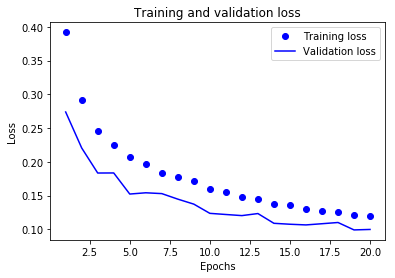

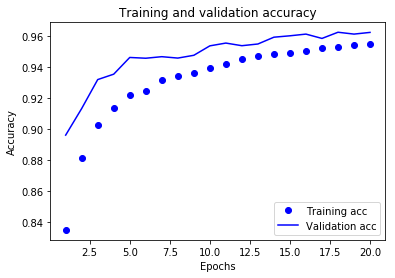

In [148]:
from keras.callbacks import History 
#history = History()
history_dict = history.history
dict_keys=(['val_loss', 'acc', 'loss', 'val_acc'])
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # очистка фигуры
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()



In [149]:
#model.save("./models/baseline_model.h5")
model.save("baseline_modelD2048_10")
print("Done!")

Done!


In [150]:
#model.save("./models/baseline_model.h5")
model.save("baseline_modelnurD2048_10")
print("Done!")

Done!


In [127]:
%%time
y0_score=[]
y1_score=[]
score = model.evaluate(Xtest, Ytest, verbose=0)
print(len(Ytest))
score = model.predict(Xtest, batch_size=1)
for ii in range(len(Ytest)):
    y0_score.append(score[ii][0])
    y1_score.append(score[ii][1])
    #######################print(Ytest[ii],'   ',score[ii][0])
    if ii%500 == 0:
        print('I=',ii)
y0_score=np.array(y0_score)
y1_score=np.array(y1_score)

10000


KeyboardInterrupt: 

In [128]:
from sklearn.metrics import roc_auc_score
#print(Ytest)
print('ROC_AUC =',roc_auc_score(Ytest, y1_score))
from scipy.optimize import brentq
from scipy.interpolate import interp1d
#from sklearn.metrics import roc_curve
#from sklearn import metrics
#y = np.array([1, 1, 2, 2])
#scores = np.array([0.1, 0.4, 0.35, 0.8])
#fpr, tpr, thresholds = metrics.roc_curve(y, scores, pos_label=2)
#print(fpr)
#array([0. , 0. , 0.5, 0.5, 1. ])
#print(tpr)
#array([0. , 0.5, 0.5, 1. , 1. ])
#print(thresholds)
#array([1.8 , 0.8 , 0.4 , 0.35, 0.1 ])

fpr, tpr, thresholds = metrics.roc_curve(Ytest, y1_score, pos_label=None)
###########print('fpr ',fpr)

##############print('tpr ',tpr)

###################print(thresholds)

print(len(y1_score))
print('ROC_AUC =',roc_auc_score(Ytest, y1_score))


#def compute_roc_EER(fpr, tpr):
#    roc_EER = []
#    cords = zip(fpr, tpr)
#    for item in cords:
#        item_fpr, item_tpr = item
#        if item_tpr + item_fpr == 1.0:
#            roc_EER.append((item_fpr, item_tpr))
#    assert(len(roc_EER) == 1.0)
#    return np.array(roc_EER)

#berr=compute_roc_EER(fpr, tpr)
#print(berr)


#from scipy.optimize import brentq
#from scipy.interpolate import interp1d
#from sklearn.metrics import roc_curve

#fpr, tpr, thresholds = roc_curve(y, y_score, pos_label=1)

eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
thresh = interp1d(fpr, thresholds)(eer)
print('   Метрика EER  ',eer*100, '%')
############################################print(thresh)
dpi = 80
fig = plt.figure(dpi = dpi, figsize = (512 / dpi, 384 / dpi) )


x = fpr# false_positive_rate
y = tpr# true_positive_rate
# This is the ROC curve
plt.plot(x,y)





ValueError: Found input variables with inconsistent numbers of samples: [10000, 0]

In [130]:
keras.backend.clear_session()
model = create_model()

loss, acc1 = model.evaluate(Xtest, Ytest)
print(acc1)






#model.load_weights(checkpoint_path)
model.load_weights("baseline_model")
loss,acc = model.evaluate(Xtest, Ytest)
print(acc)




10000/10000 [==============================] - ETA: 51s - loss: 0.6950 - acc: 0.56 - ETA: 4s - loss: 0.7112 - acc: 0.4792 - ETA: 2s - loss: 0.7129 - acc: 0.486 - ETA: 2s - loss: 0.7151 - acc: 0.470 - ETA: 1s - loss: 0.7150 - acc: 0.477 - ETA: 1s - loss: 0.7161 - acc: 0.472 - ETA: 1s - loss: 0.7138 - acc: 0.475 - ETA: 1s - loss: 0.7105 - acc: 0.484 - ETA: 1s - loss: 0.7067 - acc: 0.492 - ETA: 1s - loss: 0.7047 - acc: 0.495 - ETA: 0s - loss: 0.7029 - acc: 0.498 - ETA: 0s - loss: 0.7007 - acc: 0.504 - ETA: 0s - loss: 0.6987 - acc: 0.510 - ETA: 0s - loss: 0.6990 - acc: 0.508 - ETA: 0s - loss: 0.6974 - acc: 0.512 - ETA: 0s - loss: 0.6963 - acc: 0.515 - ETA: 0s - loss: 0.6964 - acc: 0.515 - ETA: 0s - loss: 0.6958 - acc: 0.517 - ETA: 0s - loss: 0.6956 - acc: 0.516 - ETA: 0s - loss: 0.6956 - acc: 0.517 - ETA: 0s - loss: 0.6956 - acc: 0.517 - ETA: 0s - loss: 0.6956 - acc: 0.517 - ETA: 0s - loss: 0.6955 - acc: 0.517 - 1s 130us/sample - loss: 0.6955 - acc: 0.5176
0.5176


ValueError: Shapes (2580, 80) and (1290, 300) are incompatible

In [ ]:
print("Необученная модель, точность: {:5.2f}%".format(100*acc1))
print("Восстановленная модель, точность: {:5.2f}%".format(100*acc))

In [304]:
import Metrics
#predict(x, batch_size=None, verbose=0, steps=None, callbacks=None)
prediction = model.predict(Xtest, batch_size=1)
#prediction.ravel()
#print(prediction[0][0])
#h=0
#s=0
h = prediction[:Xtest, 0]
s = prediction[Xtest:, 0]
val_eer = Metrics.compute_err(h, s)[0]

        
print("%sEER = %0.3f%%" % (" "*20, val_eer))


TypeError: only integer scalar arrays can be converted to a scalar index

In [305]:
score = model.predict(Xtest, batch_size=1)
print(score[0])



[9.9588314e-04 9.9900419e-01 3.1190228e-10 3.3306924e-10 3.5440570e-10
 3.7507603e-10 3.2008241e-10 3.5549841e-10 2.7776531e-10 2.5367877e-10
 3.8161022e-10 4.3167361e-10 3.3774178e-10 2.6097469e-10 2.8970529e-10
 3.3250372e-10 2.4192628e-10 3.3190367e-10 3.9819170e-10 4.7021298e-10]


In [74]:
abc=Xtest[0]
print(abc)
abc=np.array(abc)

[-1.43357621 -1.47873784 -1.64535246 ... -1.19607864 -0.43864517
  0.33895038]


In [114]:
mm=1
for ij in range(mm):
    lst=[]
    
    feat = get_myfeature(train_spoof[ij], length=66000, random_start=False)

    mfccs = librosa.feature.mfcc(feat, sr=fs, n_mfcc=10)
    mfccs = sklearn.preprocessing.scale(mfccs, axis=1)
    mfccs=mfccs.ravel()
    lst= list(mfccs)
    
    
    

In [115]:
print(lst)
print(len(lst))

lst= np.array(lst)
#lst.reshape(1,1290)
lst.shape

[-3.8801700307832, -3.903873108400586, -3.8343508110158724, -2.258155127167772, -0.7711737204987483, -0.32558594559231707, -0.38388955596373353, 0.3838906501523535, 1.1574866364680736, 1.2702117691317656, 0.9384518805623633, 0.4825171508337736, 0.7907488453771239, 0.5159947873357357, 0.19739264585238536, 0.7259214556304423, 0.6756662282788749, 0.6998711305117038, 0.871445958125778, 0.44453073304978746, 0.7047958385217495, 0.5793717909204886, -0.09565812593503101, 0.4285523252871903, 0.7598534518382497, 0.8802049636026987, 0.43231540493757326, -0.2417718007477556, 0.7170572405681246, 1.1600287064655634, 1.0517169737977494, 0.4336908501785268, 0.2023928616126285, 0.15884170943662348, 0.2469962067511418, 0.1379882803942369, 0.0767696992412987, 0.7503961473605105, 0.8758837412999654, 0.6807609511884074, 0.7195543822037302, 0.71292924687395, 0.5969769454403371, 0.32317738064054935, 0.4567590210171301, 0.7701214361079218, 0.45380930735715586, -0.7387930734380382, -0.8617631615400707, 0.19872


1290


(1290,)

In [ ]:
dev_get_feature = lambda path: get_feature(path, length=66000, random_start=False)

feature = dev_get_feature(os.path.join(dataset_dir, protocol_row['path']))[np.newaxis, ..., np.newaxis]

In [ ]:
for index, row in df.iterrows():
    print(row['c1'], row['c2'])


In [147]:
dataset_dir = "."
pt= "Testing_Data/sample_0007.wav"
print(os.path.join(dataset_dir, pt))

.\Testing_Data/sample_0007.wav


In [227]:
dataset_dir = "."
dev_get_feature = lambda path: get_feature(path, length=66000, random_start=False)

In [228]:
eval_protocol_path = "sample.csv"
eval_protocol = pd.read_csv(eval_protocol_path, sep=",", header=None)
eval_protocol.columns = ['path', 'key']

In [229]:
eval_protocol = eval_protocol.drop([0])
#eval_protocol = eval_protocol.drop(['key'], axis=1)
eval_protocol.head()
eval_protocol.describe()
eval_protocol.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 2 columns):
path    10000 non-null object
key     10000 non-null object
dtypes: object(2)
memory usage: 234.4+ KB


In [230]:
for protocol_id, protocol_row in list(eval_protocol.iterrows()):
    if protocol_id<5:
        feature = get_myfeature(os.path.join(dataset_dir, protocol_row['path']))#[np.newaxis, ..., np.newaxis]
        mfccs = librosa.feature.mfcc(feature, sr=fs, n_mfcc=10)
        mfccs = sklearn.preprocessing.scale(mfccs, axis=1)
        
        print(protocol_id)
        print(feature)
    #print(os.path.join(dataset_dir, pt))
    #feature = dev_get_feature(os.path.join(dataset_dir, protocol_row['path']))[np.newaxis, ..., np.newaxis]
   # feature = get_feature(os.path.join(dataset_dir, pt), length=66000, random_start=False)

1
[-0.00042725 -0.00039673 -0.00112915 ... -0.01858521 -0.02078247
 -0.02590942]
2
[ 3.0517578e-05 -3.0517578e-05  0.0000000e+00 ... -2.1057129e-03
 -2.1362305e-03 -1.8920898e-03]
3
[-0.00033569 -0.00030518 -0.00036621 ... -0.10446167 -0.10211182
 -0.09680176]
4
[-3.0517578e-05  1.2207031e-04  3.0517578e-05 ...  9.0942383e-03
  1.0406494e-02  1.0925293e-02]


In [209]:
feature = get_feature("./Testing_Data/sample_0000.wav", length=66000, random_start=False)
print(feature)

[-0.00073614 -0.00068356 -0.00194553 ... -0.03202229 -0.03580818
 -0.04464192]


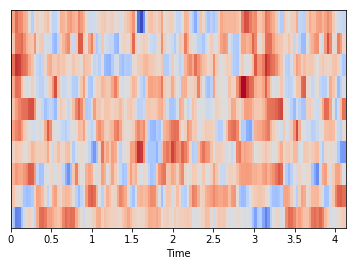

In [210]:
librosa.display.specshow(mfccs, sr=16000, x_axis='time')

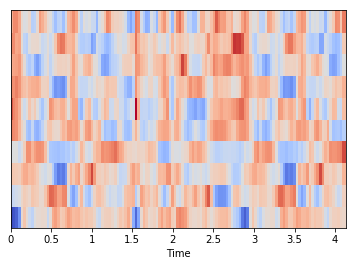

In [213]:
librosa.display.specshow(mfccs, sr=16000, x_axis='time')

In [ ]:
%%time
element_rating=[]
countelement_rating=0
for ij in range(len(ratings.index)):
    if ratings['element_uid'][ij] not in element_rating:
        element_rating.append(ratings['element_uid'][ij]) 
        countelement_rating=countelement_rating+1
print(countelement_rating)

ratings.tail()

In [ ]:
filtered_train = defaultdict(set)

for user_uid, element_uid in (data.loc[:, ['user_uid', 'element_uid']].values):
    if user_uid  in test_users:
        continue
    filtered_train[user_uid].add(element_uid)

In [ ]:
baseline_model

In [ ]:
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier

iris = datasets.load_iris()
X = iris.data
y = iris.target

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=0)

classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=0))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)



#ROC  ROC  ROC 




fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
#Generate a test signal, a 2 Vrms sine wave whose frequency is slowly modulated 
#around 3kHz, corrupted by white noise of exponentially decreasing magnitude sampled at 10 kHz.


fs = 10e3
N = 1e5
amp = 2 * np.sqrt(2)
noise_power = 0.01 * fs / 2
time = np.arange(N) / float(fs)
mod = 500*np.cos(2*np.pi*0.25*time)
carrier = amp * np.sin(2*np.pi*3e3*time + mod)
noise = np.random.normal(scale=np.sqrt(noise_power), size=time.shape)
noise *= np.exp(-time/5)
x = carrier + noise

#Compute and plot the spectrogram.

f, t, Sxx = signal.spectrogram(x, fs)
plt.pcolormesh(t, f, Sxx)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()


In [ ]:
def test_magphase():
 
    (y, sr) = librosa.load('data/test1_22050.wav')
 
    D = librosa.stft(y)
 
    S, P = librosa.magphase(D)
 
    assert np.allclose(S * P, D)

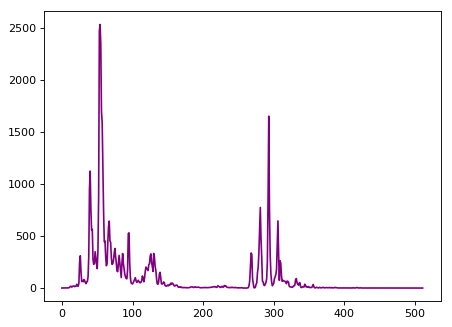

In [29]:
dpi = 80
fig = plt.figure(dpi = dpi, figsize = (512 / dpi, 384 / dpi) )

spec=Xtrn[9]
x = np.arange(0.0,len(spec) , 1)
y = np.array(spec,dtype=np.float)
plt.plot(x, y,color = 'purple')

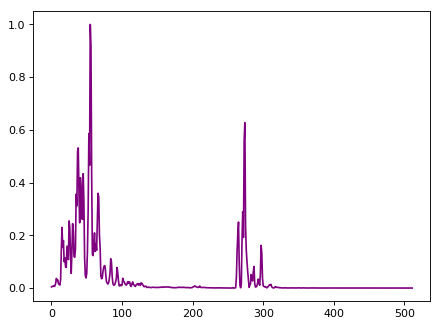

In [46]:
dpi = 80
fig = plt.figure(dpi = dpi, figsize = (512 / dpi, 384 / dpi) )

spec=Xtest[2]
maxsp=np.max(np.abs(spec))
if  maxsp>0 :
    spec=spec/ maxsp

x = np.arange(0.0,len(spec) , 1)
y = np.array(spec,dtype=np.float)
plt.plot(x, y,color = 'purple')

In [42]:
Ytest= np.array(Ytest)


Xtest = np.array(Xtest)
#Xtest = Xtest.reshape(-1,lensign)
Xtest = Xtest.reshape(-1,koef)
Xtest.shape

(3, 512)